# Introduction to Python and Natural Language Technologies

__Lecture 9, Sequence modeling__

__Nov 18, 2020__

__Judit Ács__

# Agenda

1. Overview of sequence modeling
    - Sequence elements
    - Types of models
    - Some applications
2. A bare bone sequence classification example
    - Cover the details of modeling and training
    - Data preparation with Pandas
    - Training on a small task that runs quickly on a laptop CPU 
    - Use advanced Python features instead of `torchtext`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

Standard `torch` imports:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sequence elements

We deal with sequences in NLP:
- a token is a sequence of characters/morphemes
- a sentence is a sequence of tokens
- a paragraph is a sequence of sentences
- a dialogue is a sequence of utterances
- etc.

What are the elements of these sequences?

## Words

Pros:

- More or less well-defined in most languages
- Relatively short sequences (a sentence is rarely longer than 30 tokens)

Cons:
- Difficult tokenization in some languages
- Large vocabulary (100,000+ easily)
- Out-of-vocabulary words are always there regardless of the size of the vocabulary
- Many rare words
    - Hapax: a word that only appears once in the dataset.

## Characters

Pros:
- Smaller vocabulary although logographic writing systems (Chinese and Japanese) have thousands of characters
- Easy tokenization
- Well defined: Unicode symbols

Cons:
- Long sequences
- Too fine-grained, token level information is lost

## Subwords

- Multiple characters but smaller than words
- Modern language models use subword vocabularies
- We will cover these next week

# Sequence classification

Assign a single label to the full sequence:

<img src="img/tikz/abstract_sequence_classification.png" width="350" />

__Applications__

- Topic classification (AG News dataset from Lab 9)
- Sentiment analysis: is this sentence or paragraph a positive (1) or a negative (0) review?

<img src="img/tikz/example_sequence_classification.png" width="500" />

# Sequence tagging

Assign a label to each element of the sequence:

<img src="img/tikz/abstract_sequence_tagging.png">

__Applications__

- part-of-speech tagging
- named entity recognition (NER)

<img src="img/tikz/example_sequence_tagging.png" >

# Seq2seq

<img src="img/tikz/abstract_seq2seq.png" width=600px>

- Maps a source sequence to a target sequence
    - Arbitrary length
- Two steps:
    1. Encode: create a representation of the source
    2. Decode: generate the target representation
        - autoregressive: generate tokens one-by-one (condition on the left context)
        
- Usually implemented as two separate neural networks for example:
    - The encoder is a bidirectional LSTM
    - The decoder is a unidirectional LSTM
    
- Applications:
    - Neural machine translation
    - Morphological analysis

# Attention

Seq2seq performs poorly in its naive form since the decoder has to generate the whole output based on a single hidden vector that represents the full input sequence.

**Attention** gives peak into the input sequence [image source](https://aihub.cloud.google.com/u/0/p/products%2F024b89fd-9bc8-4c24-b8a8-e347479f3270):
    
<img src="img/dl/attention_mechanism.jpg" width=600px>

# Other tasks

There are many other NLP tasks that are solved with some combination of the above models.

- Sentence pair classification: the same as sequence classification except we assign a label to a __pair__ of sentences
- Examples:
    - paraphrase identification
- Span level tasks

# Sequence classification example

We will now train a sequence classification model on Hungarian morphology. This model can be trained on a laptop CPU.

## Backpropagation


Neural networks are usually trained with the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm.

The data flow in neural networks implicitly defines a **computation graph**, this is called **forward pass**.

The output is compared against the ground truth or label and the difference or cost is quantified by **loss function** also called **cost function**.

If the loss function is differentiable with respect to the parameters, we can compute the gradient w.r.t. to all parameters i.e. we can quantify 'how responsible' a parameter is for the loss using the chain rule. This is called **backpropagation**.

An optimizer then updates the parameters. The update is proportional to the gradient. This is called **gradient descent**.

More information: [Backpropagation chapter](https://www.deeplearningbook.org/contents/mlp.html#pf25) from [Deep Learning](https://www.deeplearningbook.org/) by Goodfellow, Bengio and Courville

We will now discuss the building blocks of the sequence classifier.

## `nn.Embedding`

`nn.Embedding` maps integers to continuous vectors. Its mandatory parameters are:
- `num_embeddings`: the size of the vocabulary
- `embedding_dim`: the size of the embedding

In [3]:
embedding = nn.Embedding(5, 3)
embedding(torch.LongTensor([1, 4]))
# embedding(torch.LongTensor([1, 5]))  # raises IndexError

tensor([[ 1.3559, -0.9057, -1.1132],
        [ 0.2409,  0.2470, -0.4559]], grad_fn=<EmbeddingBackward>)

Works with higher order tensors:

In [4]:
input_tensor = torch.LongTensor(
    [[1, 2], [0, 1]]
)
emb = embedding(input_tensor)
print(f"{input_tensor.size() = }")
print(f"{emb.size() = }")
emb

input_tensor.size() = torch.Size([2, 2])
emb.size() = torch.Size([2, 2, 3])


tensor([[[ 1.3559, -0.9057, -1.1132],
         [-0.2540,  0.1833, -0.6589]],

        [[ 0.7465, -1.5062, -0.2970],
         [ 1.3559, -0.9057, -1.1132]]], grad_fn=<EmbeddingBackward>)

In [5]:
input_tensor = torch.LongTensor(
    [[[1, 2], [0, 1]]]
)
emb = embedding(input_tensor)
print(f"{input_tensor.size() = }")
print(f"{emb.size() = }")
emb

input_tensor.size() = torch.Size([1, 2, 2])
emb.size() = torch.Size([1, 2, 2, 3])


tensor([[[[ 1.3559, -0.9057, -1.1132],
          [-0.2540,  0.1833, -0.6589]],

         [[ 0.7465, -1.5062, -0.2970],
          [ 1.3559, -0.9057, -1.1132]]]], grad_fn=<EmbeddingBackward>)

## `nn.LSTM`

LSTM is the most popular recurrent cell that takes a sequence as an input and processes it one by one while updating its hidden state. Its parameters are (from [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM)):
- `input_size`: The number of expected features in the input x
- `hidden_size`: The number of features in the hidden state h
- `num_layers`: Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
- `bias`: If False, then the layer does not use bias weights b_ih and b_hh. Default: True
- `batch_first`: If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
- `dropout`: If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
- `bidirectional`: If True, becomes a bidirectional LSTM. Default: False

Its input **must** be 3D:

In [6]:
lstm = nn.LSTM(5, 12, num_layers=1, bidirectional=False, batch_first=True, dropout=0)

input_tensor = torch.rand((3, 2))
# lstm(input_tensor)  # raises RunTimeError

In [7]:
# batch_size X sequence_length X input_size
# 3 X 2 X 5
input_tensor = torch.rand((3, 2, 5))
outputs, (h, c) = lstm(input_tensor)

print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

outputs.size() = torch.Size([3, 2, 12])
h.size() = torch.Size([1, 3, 12])
c.size() = torch.Size([1, 3, 12])


In practice we generally use bidirectional LSTMs, which are implemented as two unidirectional LSTMs.

`h` and `c` are now the final states of both unidirectional LSTMs:

In [8]:
lstm = nn.LSTM(5, 12, num_layers=1, bidirectional=True, batch_first=True, dropout=0)

input_tensor = torch.rand((3, 2, 5))
outputs, (h, c) = lstm(input_tensor)

print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

outputs.size() = torch.Size([3, 2, 24])
h.size() = torch.Size([2, 3, 12])
c.size() = torch.Size([2, 3, 12])


In [9]:
lstm = nn.LSTM(5, 12, num_layers=3, bidirectional=True, batch_first=True, dropout=0)

input_tensor = torch.rand((3, 2, 5))
outputs, (h, c) = lstm(input_tensor)

print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

outputs.size() = torch.Size([3, 2, 24])
h.size() = torch.Size([6, 3, 12])
c.size() = torch.Size([6, 3, 12])


## Combining `nn.LSTM` with `nn.Embedding`

In [10]:
# model parameters
vocab_size = 10
embedding_size = 5
lstm_hidden_size = 6

embedding = nn.Embedding(vocab_size, embedding_size)
lstm = nn.LSTM(embedding_size, lstm_hidden_size, num_layers=1, bidirectional=True, batch_first=True, dropout=0)

In [11]:
# input parameters (not that these are independent of the model)
batch_size = 3
sequence_length = 4

input_ids = torch.randint(vocab_size, (batch_size, sequence_length))
input_ids

tensor([[9, 4, 3, 1],
        [6, 2, 4, 5],
        [7, 9, 7, 3]])

In [12]:
embedded = embedding(input_ids)
outputs, (h, c) = lstm(embedded)

print(f"{input_ids.size() = }")
print(f"{embedded.size() = }")
print(f"{outputs.size() = }")
print(f"{h.size() = }")
print(f"{c.size() = }")

input_ids.size() = torch.Size([3, 4])
embedded.size() = torch.Size([3, 4, 5])
outputs.size() = torch.Size([3, 4, 12])
h.size() = torch.Size([2, 3, 6])
c.size() = torch.Size([2, 3, 6])


## `nn.Linear`

`nn.Linear` implements a matrix projection:

In [13]:
dense = nn.Linear(3, 5)
input_tensor = torch.rand((2, 3))
output = dense(input_tensor)
print(f"{output.size() = }")

output.size() = torch.Size([2, 5])


Inner dimensions must match:

In [14]:
input_tensor = torch.rand((2, 4))
# output = dense(input_tensor)  # raises RuntimeError

## The `LSTMTagger` class

We can now define our own LSTM sequence tagger model.

All PyTorch modules must subclass `nn.Module` (or one of its subclasses) and call `init` before any attribute assignment.

There two methods we have to implement:
- `__init__`: defines submodules. These constitute the nodes _computation graph_.
- `forward` implements the forward pass of the module. This is how we map the input to the output. The way we pass the input through the module implicitly builds a directed graph of the submodules named _computation graph_.

The backward pass is automatically handled by PyTorch but it can be overriden by implementind the `backward` method.

In [15]:
class LSTMTagger(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, sequences):
        # sequences: batch_size X sequence_length
        embedded = self.embedding(sequences)
        
        # lstm_outputs: batch_size X sequence_length X 2*hidden_size
        # h: 2 X batch_size X hidden_size
        # c: 2 X batch_size X hidden_size
        lstm_outputs, (h, c) = self.lstm(embedded)
        
        # h: batch_size X 2*hidden_size
        h = torch.cat((h[0], h[1]), dim=-1)
        
        # output: batch_size X output_size
        output = self.dense(h)
        return output
        
        
toy_tagger = LSTMTagger(3, 10, 5, 2)
toy_input = torch.LongTensor([
    [0, 1, 0, 2],
    [0, 1, 0, 2],
    [0, 0, 0, 2],
    [1, 1, 2, 0],
])
toy_tagger(toy_input)

tensor([[ 0.4721, -0.1142],
        [ 0.4721, -0.1142],
        [ 0.4738, -0.1378],
        [ 0.4507, -0.0510]], grad_fn=<AddmmBackward>)

### Under the hood

PyTorch registers every attribute in `__init__` that is an instance of `nn.Module` in the parameters of the module:

In [16]:
for param in toy_tagger.named_parameters():
    print(f"name: {param[0]}, size: {param[1].size()}")

name: embedding.weight, size: torch.Size([3, 10])
name: lstm.weight_ih_l0, size: torch.Size([20, 10])
name: lstm.weight_hh_l0, size: torch.Size([20, 5])
name: lstm.bias_ih_l0, size: torch.Size([20])
name: lstm.bias_hh_l0, size: torch.Size([20])
name: lstm.weight_ih_l0_reverse, size: torch.Size([20, 10])
name: lstm.weight_hh_l0_reverse, size: torch.Size([20, 5])
name: lstm.bias_ih_l0_reverse, size: torch.Size([20])
name: lstm.bias_hh_l0_reverse, size: torch.Size([20])
name: dense.weight, size: torch.Size([2, 10])
name: dense.bias, size: torch.Size([2])


This is **not** true for lists and other complex data types. PyTorch does not attempt to traverse them:

In [17]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [nn.Linear(12, 4), nn.Linear(15, 9)]
        
for param in SimpleModule().parameters():
    print(param.size())

The solution is `nn.ModuleList` or `nn.Sequential`:

In [18]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(12, 4), nn.Linear(15, 9)])
        
for param in SimpleModule().named_parameters():
    print(f"name: {param[0]}, size: {param[1].size()}")

name: layers.0.weight, size: torch.Size([4, 12])
name: layers.0.bias, size: torch.Size([4])
name: layers.1.weight, size: torch.Size([9, 15])
name: layers.1.bias, size: torch.Size([9])


`nn.Sequential` chains multiple modules:

In [19]:
class SimpleModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(12, 4),
            nn.ReLU(),
            nn.Linear(15, 9),
            nn.Tanh(),
        )
        
    def forward(self, input):
        out = self.layers(out)
        return out
    
        
for param in SimpleModule().named_parameters():
    print(f"name: {param[0]}, size: {param[1].size()}")

name: layers.0.weight, size: torch.Size([4, 12])
name: layers.0.bias, size: torch.Size([4])
name: layers.2.weight, size: torch.Size([9, 15])
name: layers.2.bias, size: torch.Size([9])


## Data preparation

We will now train a small classifier that predicts the case of Hungarian nouns. Hungarian has a rich case system in place of prefixes used by English. Some examples are:

| Case | Hungarian | English |
| ---- | ---- | ---- |
| Nominative | ház | house |
| Instrumental | házzal | with (a) house |
| Ablative  | háztól | from at (a) house |
| Elativus  | házból | from inside (a) house |


We will train a character-level model that predicts the case based on the word form. This is an easy task since most of the time the grammatical case is obvious from the last 3 characters of the word.

Our model looks like this:

<img src="img/tikz/hungarian_case_lstm.png" width=600px>

In [20]:
train_df = pd.read_table("data/unimorph/hun_train.tsv")
dev_df = pd.read_table("data/unimorph/hun_dev.tsv")
test_df = pd.read_table("data/unimorph/hun_test.tsv")
print(len(train_df), len(dev_df), len(test_df))
train_df.head()

343484 42752 43157


,lemma,infl,tags,pos,case
0,gravitáció,gravitáción,N;ON+ESS;SG,N,ON+ESS
1,gravitáció,gravitációként,N;FRML;SG,N,FRML
2,gravitáció,gravitációkban,N;IN+ESS;PL,N,IN+ESS
3,gravitáció,gravitációkhoz,N;AT+ALL;PL,N,AT+ALL
4,gravitáció,gravitáció,N;NOM;SG,N,NOM


### Downsampling

We don't need much data to train the model, let's downsample it and train on a small subset.

In [21]:
train_df = train_df.sample(1000, random_state=1).reset_index(drop=True)
dev_df = dev_df.sample(200, random_state=1).reset_index(drop=True)
test_df = test_df.sample(200, random_state=1).reset_index(drop=True)

### Building the vocabulary

We need to map each character to an integer id. For this we need to define a `char->int` mapping that is as big as the alphabet:

In [22]:
alphabet = set()
for token in train_df.infl:
    alphabet |= set(token)
len(alphabet)

42

and some extra symbols:

1. PAD: used as filler symbols for shorter sequences (see later)
2. BOS: beginning-of-sequence. Indicates the start of the sequence.
2. EOS: end-of-sequence. Indicates the end of the sequence.
2. UNK: unknown. Symbols that fall out of the vocabulary are replaced with this symbol.

In [23]:
alphabet.add('<PAD>')
alphabet.add('<BOS>')
alphabet.add('<EOS>')
alphabet.add('<UNK>')

In [24]:
vocab = {symbol: i for i, symbol in enumerate(alphabet)}
len(vocab)

46

In [25]:
def encode_token(token):
    ids = []
    ids.append(vocab['<BOS>'])
    # dev and test might contain characters outside the alphabet
    ids.extend(vocab.get(c, vocab['<UNK>']) for c in token)
    ids.append(vocab['<EOS>'])
    return ids

print(f"{encode_token('alma') = }")
print(f"{vocab['<UNK>'] = }")
print(f"{encode_token('ALMA') = }")

encode_token('alma') = [30, 11, 19, 36, 11, 18]
vocab['<UNK>'] = 42
encode_token('ALMA') = [30, 42, 42, 42, 42, 18]


Let's encode our dataset:

In [26]:
train_df['encoded'] = train_df.infl.apply(encode_token)
dev_df['encoded'] = dev_df.infl.apply(encode_token)
test_df['encoded'] = test_df.infl.apply(encode_token)
train_df.head()

,lemma,infl,tags,pos,case,encoded
0,fülbemászó,fülbemászóként,N;FRML;SG,N,FRML,"[30, 6, 35, 19, 21, 3, 36, 44, 45, 9, 20, 29, ..."
1,feszültebb,feszültebbet,N;ACC;SG,N,ACC,"[30, 6, 3, 45, 9, 35, 19, 32, 3, 21, 21, 3, 32..."
2,olajfa,olajfára,N;ON+ALL;SG,N,ON+ALL,"[30, 7, 19, 11, 15, 6, 44, 34, 11, 18]"
3,prostitúció,prostitúciókat,N;ACC;PL,N,ACC,"[30, 26, 34, 7, 45, 32, 1, 32, 43, 41, 1, 20, ..."
4,alt,alttá,N;TRANS;SG,N,TRANS,"[30, 11, 19, 32, 32, 44, 18]"


### Padding

The input sequences different in length at the moment:

<AxesSubplot:xlabel='infl', ylabel='count'>

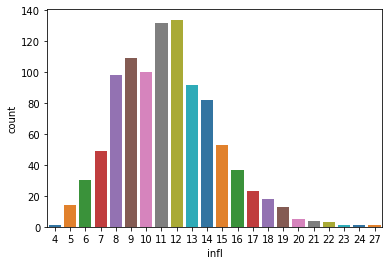

In [27]:
sns.countplot(x=train_df.infl.str.len(), palette='tab10')

We append **PAD** symbols to the shorter sequences like this:

<img src="img/tikz/padding.png">

In [28]:
maxlen = train_df.encoded.apply(len).max()
print(maxlen)

def pad_sequence(sequence):
    if len(sequence) > maxlen:
        return sequence[:maxlen]
    return sequence + [vocab['<PAD>'] for _ in range(maxlen-len(sequence))]

print(pad_sequence([1, 2, 3]))

29
[1, 2, 3, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]


In [29]:
train_df['padded'] = train_df.encoded.apply(pad_sequence)
dev_df['padded'] = dev_df.encoded.apply(pad_sequence)
test_df['padded'] = test_df.encoded.apply(pad_sequence)

train_df['padded'].apply(len).value_counts()

29    1000
Name: padded, dtype: int64

We will need the original lengths of each sequence later:

In [30]:
train_df['seqlen'] = train_df.encoded.apply(len)
dev_df['seqlen'] = dev_df.encoded.apply(len)
test_df['seqlen'] = test_df.encoded.apply(len)

### Preparing labels

There are 18 labels:

In [31]:
label_to_id = {label: i for i, label in enumerate(train_df.case.unique())}
label_to_id

{'FRML': 0,
 'ACC': 1,
 'ON+ALL': 2,
 'TRANS': 3,
 'IN+ALL': 4,
 'AT+ALL': 5,
 'IN+ESS': 6,
 'ON+ABL': 7,
 'IN+ABL': 8,
 'INST': 9,
 'TERM': 10,
 'AT+ESS': 11,
 'PRP': 12,
 'AT+ABL': 13,
 'NOM': 14,
 'ON+ESS': 15,
 'DAT': 16}

We add a `label` column to each dataframe:

In [32]:
train_df['label'] = train_df.case.apply(lambda c: label_to_id[c])
dev_df['label'] = dev_df.case.apply(lambda c: label_to_id[c])
test_df['label'] = test_df.case.apply(lambda c: label_to_id[c])

In [33]:
train_df.head()

,lemma,infl,tags,pos,case,encoded,padded,seqlen,label
0,fülbemászó,fülbemászóként,N;FRML;SG,N,FRML,"[30, 6, 35, 19, 21, 3, 36, 44, 45, 9, 20, 29, ...","[30, 6, 35, 19, 21, 3, 36, 44, 45, 9, 20, 29, ...",16,0
1,feszültebb,feszültebbet,N;ACC;SG,N,ACC,"[30, 6, 3, 45, 9, 35, 19, 32, 3, 21, 21, 3, 32...","[30, 6, 3, 45, 9, 35, 19, 32, 3, 21, 21, 3, 32...",14,1
2,olajfa,olajfára,N;ON+ALL;SG,N,ON+ALL,"[30, 7, 19, 11, 15, 6, 44, 34, 11, 18]","[30, 7, 19, 11, 15, 6, 44, 34, 11, 18, 14, 14,...",10,2
3,prostitúció,prostitúciókat,N;ACC;PL,N,ACC,"[30, 26, 34, 7, 45, 32, 1, 32, 43, 41, 1, 20, ...","[30, 26, 34, 7, 45, 32, 1, 32, 43, 41, 1, 20, ...",16,1
4,alt,alttá,N;TRANS;SG,N,TRANS,"[30, 11, 19, 32, 32, 44, 18]","[30, 11, 19, 32, 32, 44, 18, 14, 14, 14, 14, 1...",7,3


#### Extract input and output tensors

In [34]:
X_train = torch.from_numpy(np.array(list(train_df.padded)))
y_train = torch.LongTensor(train_df.label.values)
seqlen_train = torch.LongTensor(train_df.seqlen.values)
print(f"{X_train.size() = },\n{y_train.size() = }\n{seqlen_train.size() = }\n")

X_dev = torch.from_numpy(np.array(list(dev_df.padded)))
y_dev = torch.LongTensor(dev_df.label.values)
seqlen_dev = torch.LongTensor(dev_df.seqlen.values)
print(f"{X_dev.size() = },\n{y_dev.size() = }\n{seqlen_dev.size() = }\n")

X_test = torch.from_numpy(np.array(list(test_df.padded)))
y_test = torch.LongTensor(test_df.label.values)
seqlen_test = torch.LongTensor(test_df.seqlen.values)
print(f"{X_test.size() = },\n{y_test.size() = }\n{seqlen_test.size() = }")

X_train.size() = torch.Size([1000, 29]),
y_train.size() = torch.Size([1000])
seqlen_train.size() = torch.Size([1000])

X_dev.size() = torch.Size([200, 29]),
y_dev.size() = torch.Size([200])
seqlen_dev.size() = torch.Size([200])

X_test.size() = torch.Size([200, 29]),
y_test.size() = torch.Size([200])
seqlen_test.size() = torch.Size([200])


## `PackedSequence`

We need to modify `LSTMTagger` to support padding. The last output is now different for each sequence:

<img src="img/tikz/padding_last_highlight.png">

In [35]:
class LSTMTagger(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )
        self.dense = nn.Linear(hidden_size * 2, output_size)
        
    # the input signature of forward changes
    def forward(self, sequences, sequence_lens):
        embedded = self.embedding(sequences)
        
        # THIS IS THE MODIFIED PART
        # returns a PackedSequence object
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            sequence_lens,
            enforce_sorted=False,
            batch_first=True)
        packed_outputs, (h, c) = self.lstm(packed)
        # extract LSTM outputs (not used here)
        lstm_outputs, lens = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        h = torch.cat((h[0], h[1]), dim=-1)
        output = self.dense(h)
        return output

## Instantiating the model

The input and the output size are determined by the alphabet and the number of labels, the rest are up to us:

In [36]:
input_size = len(vocab)
embedding_size = 30
hidden_size = 64
output_size = train_df.label.nunique()

tagger = LSTMTagger(input_size, embedding_size, hidden_size, output_size)
tagger

LSTMTagger(
  (embedding): Embedding(46, 30)
  (lstm): LSTM(30, 64, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=128, out_features=17, bias=True)
)

## Batching

Most datasets do not fit into the GPU memory so we process them in smaller chunks called _batches_.

There are many solutions for batching but it can also be implemented with simple class.

Note that the init function takes an arbitrary number of positional arguments (`*tensors`) and one mandatory keyword (`batch_size`). This class is a simplified version of batching, it lacks many features such as shuffling or sorting by sequence length.

In [37]:
class BatchedIterator:
    def __init__(self, *tensors, batch_size):
        # all tensors must have the same first dimension
        assert len(set(len(tensor) for tensor in tensors)) == 1
        self.tensors = tensors
        self.batch_size = batch_size
    
    def iterate_once(self):
        num_data = len(self.tensors[0])
        for start in range(0, num_data, self.batch_size):
            end = start + self.batch_size
            yield tuple(tensor[start:end] for tensor in self.tensors)
            
            
print("Two tensors:")
for batch in BatchedIterator([1, 2, 3], [2, 1, 2], batch_size=2).iterate_once():
    print(batch)
    
print("\nOne tensor:")
for batch in BatchedIterator([2, 1, 2], batch_size=2).iterate_once():
    print(batch)

Two tensors:
([1, 2], [2, 1])
([3], [2])

One tensor:
([2, 1],)
([2],)


In [38]:
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=501)
for X, seqlens, y in train_iter.iterate_once():
    print(f"{X.size() = }, {seqlens.size() = }, {y.size() = }")

X.size() = torch.Size([501, 29]), seqlens.size() = torch.Size([501]), y.size() = torch.Size([501])
X.size() = torch.Size([499, 29]), seqlens.size() = torch.Size([499]), y.size() = torch.Size([499])


## Loss function and optimizer

The **loss function** or **cost function** quantifies cost of the model output differing from the expected target values.

The optimizer adjusts the model's parameters in accordance with the loss.

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tagger.parameters())

## Sanity check

Train and dev accuracy should be really bad without training.

Do **NOT** touch the test data while development finetuning.

In [40]:
logits = tagger(X_train, seqlen_train)
y = logits.argmax(axis=1)
accuracy = torch.sum(torch.eq(y, y_train)) / y.size(0)
print(f"Train accuracy: {accuracy:.1%}")

Train accuracy: 5.3%


In [41]:
logits = tagger(X_dev, seqlen_dev)
y = logits.argmax(axis=1)
accuracy = torch.sum(torch.eq(y, y_dev)) / y.size(0)
print(f"Dev accuracy: {accuracy:.1%}")

Dev accuracy: 5.0%


## Training

We collect training statistics at the end of each epochs in `metrics`.

In [42]:
num_epochs = 30
batch_size = 128

metrics = defaultdict(list)
train_iter = BatchedIterator(X_train, seqlen_train, y_train, batch_size=batch_size)

We train the model batch by batch and then evaluate it on the train and the dev data at the end of each epoch.
Since the dataset is small, we can evaluate it the whole data in one step without batching.

Note that the model should be set to **train** or **eval** mode accordingly. Stochastic steps such as dropout are disabled in **eval** mode.

In [43]:
for epoch in range(num_epochs):
    tagger.train()
    # Training loop
    for X_batch, seqlen_batch, y_batch in train_iter.iterate_once():
        y_out = tagger(X_batch, seqlen_batch)
        loss = criterion(y_out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    tagger.eval()  # or tagger.train(False)
    # Train and dev loss at the end of the epoch
    y_out = tagger(X_train, seqlen_train)
    train_loss = criterion(y_out, y_train).item()
    metrics['train_loss'].append(train_loss)
    labels = y_out.argmax(axis=1)
    train_accuracy = (torch.eq(y_train, labels).sum() / labels.size(0)).item()
    metrics['train_accuracy'].append(train_accuracy)
    
    y_out = tagger(X_dev, seqlen_dev)
    dev_loss = criterion(y_out, y_dev).item()
    metrics['dev_loss'].append(dev_loss)
    labels = y_out.argmax(axis=1)
    dev_accuracy = (torch.eq(y_dev, labels).sum() / labels.size(0)).item()
    metrics['dev_accuracy'].append(dev_accuracy)
    
    print(f"{epoch=} -- {train_loss=:.3f} - {train_accuracy=:.1%} - {dev_loss=:.3f} - {dev_accuracy=:.1%}")

epoch=0 -- train_loss=2.786 - train_accuracy=17.8% - dev_loss=2.800 - dev_accuracy=13.0%
epoch=1 -- train_loss=2.715 - train_accuracy=27.3% - dev_loss=2.737 - dev_accuracy=24.0%
epoch=2 -- train_loss=2.605 - train_accuracy=33.3% - dev_loss=2.639 - dev_accuracy=32.0%
epoch=3 -- train_loss=2.431 - train_accuracy=37.0% - dev_loss=2.479 - dev_accuracy=33.5%
epoch=4 -- train_loss=2.188 - train_accuracy=47.3% - dev_loss=2.254 - dev_accuracy=40.0%
epoch=5 -- train_loss=1.902 - train_accuracy=64.3% - dev_loss=1.980 - dev_accuracy=59.0%
epoch=6 -- train_loss=1.594 - train_accuracy=76.2% - dev_loss=1.684 - dev_accuracy=71.5%
epoch=7 -- train_loss=1.301 - train_accuracy=80.8% - dev_loss=1.396 - dev_accuracy=80.5%
epoch=8 -- train_loss=1.044 - train_accuracy=85.8% - dev_loss=1.142 - dev_accuracy=83.0%
epoch=9 -- train_loss=0.833 - train_accuracy=88.6% - dev_loss=0.932 - dev_accuracy=84.5%
epoch=10 -- train_loss=0.657 - train_accuracy=91.1% - dev_loss=0.758 - dev_accuracy=87.5%
epoch=11 -- train_lo

## Evaluation

### Training curves

<AxesSubplot:>

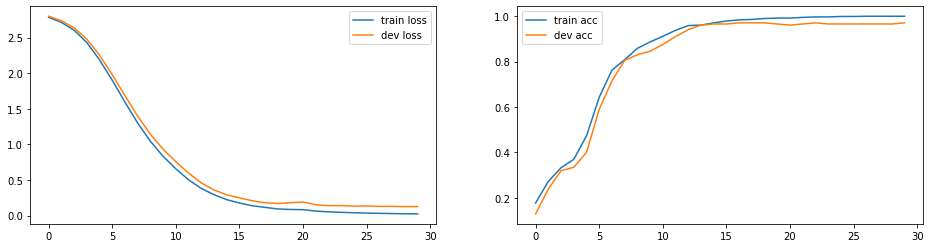

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='dev loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train acc')
sns.lineplot(data=metrics['dev_accuracy'], ax=ax[1], label='dev acc')

## Test accuracy

In [45]:
logits = tagger(X_test, seqlen_test)
test_prediction = logits.argmax(axis=1)
test_accuracy = torch.sum(torch.eq(test_prediction, y_test)) / y_test.size(0)
print(f"Test accuracy: {test_accuracy:.1%}")

Test accuracy: 98.0%


## Incorrectly classified examples

In [46]:
test_df['prediction'] = test_prediction

### Recovering labels

In [47]:
id_to_label = {i: l for l, i in label_to_id.items()}
test_df['predicted_case'] = test_df['prediction'].apply(lambda id_: id_to_label[id_])

In [48]:
test_df[test_df.prediction != test_df.label][['infl', 'case', 'predicted_case']]

,infl,case,predicted_case
41,bohóccá,TRANS,AT+ALL
44,csombord,NOM,ON+ALL
120,farkatlanok,NOM,DAT
177,sámán,NOM,ON+ESS


# Further topics

## Early stopping

Stop the training process if the development metrics no longer improve.

## Dropout

Dropout disables a random subset of neurons during each training step. It's generally set to 10-20%. Dropout usually improves generalization.

It should be disabled in evaluation steps and during inference.

## Overfitting

Fit the train set very closely but lose generalization.

[Image source](https://www.quora.com/What-are-the-key-trade-offs-between-overfitting-and-underfitting)

<img src="img/dl/overfitting.png" />

## Using the GPU

Moving things manually to the GPU:
- model: move once
- criterion: move once
- data: move one batch at a time

This should be automatically handled by your code the following way:

In [49]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [50]:
if use_cuda:
    tagger = tagger.cuda()
    criterion = criterion.cuda()

## Saving and loading models

All `nn.Modules` have a `state_dict` attribute, a dictionary of their parameters. This can be partially or fully saved with `torch.save` and loaded by `torch.load`.

(Official tutorial)[https://pytorch.org/tutorials/beginner/saving_loading_models.html]

## Inference

**Inference** is when we use the model for prediction and do not train it.

The models should be set to `eval` mode.